
# Previsão de Área Queimada em Incêndios Florestais (Forest Fires – UCI)

**Disciplina:** Machine Learning e Analytics
 
**Instituição:** PUC-Rio (Pós-graduação)

**Data:** 20/09/2025

**Matrícula:** 4052024001399

**Autor:** Carlysberg Matheus Barreto



**Resumo:** Estudo preditivo da área queimada (ha) em eventos de incêndio florestal com variáveis meteorológicas e índices do Fire Weather Index (FWI). O fluxo contempla análise exploratória, preparação de dados, baselines, modelagem, otimização, avaliação e discussão.



## 1. Introdução / Contexto
A área queimada em incêndios apresenta distribuição assimétrica, com predominância de valores nulos ou pequenos e poucos eventos extremos. O conjunto Forest Fires, de uso acadêmico, permite estudar relações entre variáveis climáticas/índices FWI e a severidade observada, em um cenário controlado e reprodutível.



## 2. Definição do Problema
**Tarefa:** regressão para estimar a área queimada (`area`, em hectares) a partir de variáveis climáticas e índices FWI.  
**Hipóteses:** (i) variáveis do FWI e do clima explicam parte da variabilidade; (ii) representação sazonal de `month`/`day` é relevante; (iii) métodos baseados em árvores capturam não linearidades e interações.




## 3. Objetivos
1. Estabelecer baselines simples.  
2. Comparar abordagens lineares e *ensembles*.  
3. Otimizar hiperparâmetros com validação cruzada.  
4. Avaliar desempenho em teste e interpretar resultados.



## 4. Descrição do Dataset
Atributos: coordenadas relativas (`X`,`Y`); índices FWI (`FFMC`,`DMC`,`DC`,`ISI`); clima (`temp`,`RH`,`wind`,`rain`); calendário (`month`,`day`). A variável-alvo `area` é contínua e esparsa. A transformação `log1p(area)` reduz a assimetria e estabiliza variância para modelos que minimizam erro quadrático.



## 5. Metodologia (Visão Geral)
1. Análise exploratória descritiva.  
2. Preparação com `ColumnTransformer` e codificação cíclica de `month`/`day`.  
3. Divisão 60/20/20 (treino/validação/teste) com *seed*.  
4. Baselines (média e mediana).  
5. Modelagem: Linear, Ridge, Lasso, Gradient Boosting, Random Forest, Tweedie.  
6. Otimização com `RandomizedSearchCV` e validação cruzada repetida.  
7. Avaliação no teste e interpretação (importâncias por permutação e quantis).


## 6. Importações e Configurações

In [1]:

import os, time, math, random, sys, platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tempfile import mkdtemp

from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, TweedieRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance

SEED = 42
np.random.seed(SEED); random.seed(SEED)
cache_dir = mkdtemp()

print("Python:", sys.version.split()[0], "| OS:", platform.platform())


Python: 3.11.9 | OS: Windows-10-10.0.19045-SP0


## 7. Carga dos Dados (URL pública)

In [2]:

DATA_URL = "https://raw.githubusercontent.com/CarlysbergBarreto/mvp-machine-learning/main/forestfires.csv"

t0 = time.time()
df = pd.read_csv(DATA_URL)
print(f"Leitura: {time.time()-t0:.2f}s | shape: {df.shape}")
display(df.head(3)); print(df.dtypes)

esperadas = ["X","Y","month","day","FFMC","DMC","DC","ISI","temp","RH","wind","rain","area"]
faltantes = [c for c in esperadas if c not in df.columns]
assert not faltantes, f"Colunas ausentes: {faltantes}"


Leitura: 0.70s | shape: (517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0


X          int64
Y          int64
month     object
day       object
FFMC     float64
DMC      float64
DC       float64
ISI      float64
temp     float64
RH         int64
wind     float64
rain     float64
area     float64
dtype: object


## 8. Análise Exploratória (EDA)

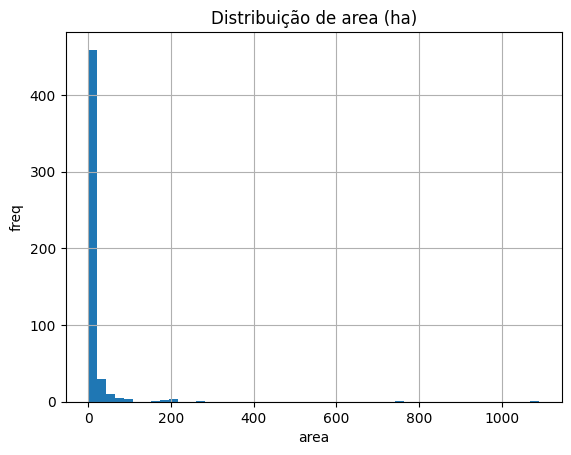

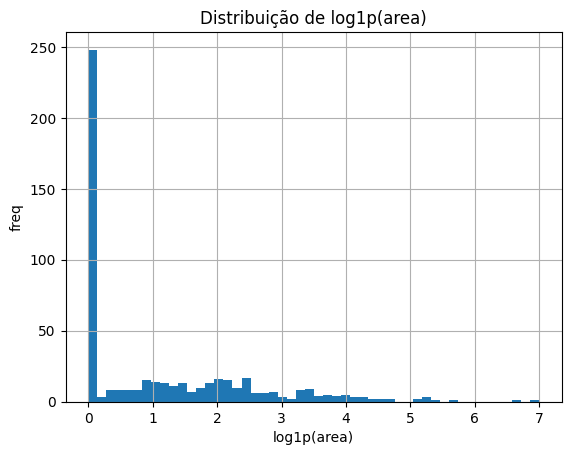

Proporção de zeros em area: 47.78%


In [3]:

# Distribuições da variável-alvo
plt.figure(); df["area"].hist(bins=50)
plt.title("Distribuição de area (ha)"); plt.xlabel("area"); plt.ylabel("freq"); plt.show()

plt.figure(); np.log1p(df["area"]).hist(bins=50)
plt.title("Distribuição de log1p(area)"); plt.xlabel("log1p(area)"); plt.ylabel("freq"); plt.show()

prop_zero = (df["area"]==0).mean()
print(f"Proporção de zeros em area: {prop_zero:.2%}")


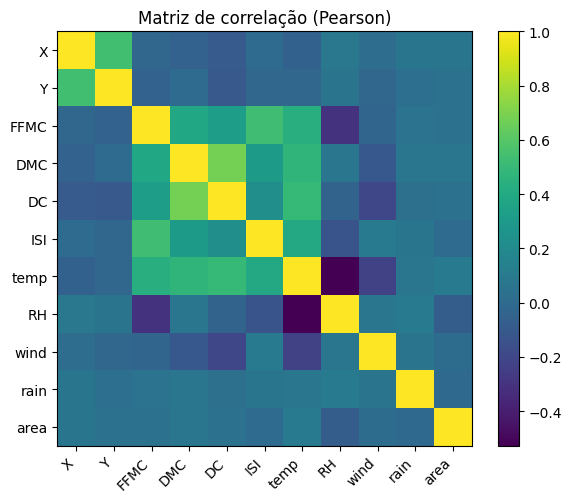

In [4]:

# Matriz de correlação (numéricas, sem 'area' transformada)
num_cols_raw = ["X","Y","FFMC","DMC","DC","ISI","temp","RH","wind","rain","area"]
corr = df[num_cols_raw].corr(numeric_only=True)

plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(num_cols_raw)), num_cols_raw, rotation=45, ha="right")
plt.yticks(range(len(num_cols_raw)), num_cols_raw)
plt.title("Matriz de correlação (Pearson)")
plt.tight_layout(); plt.show()


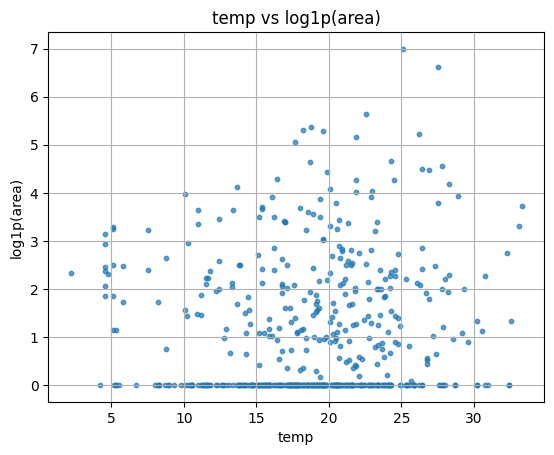

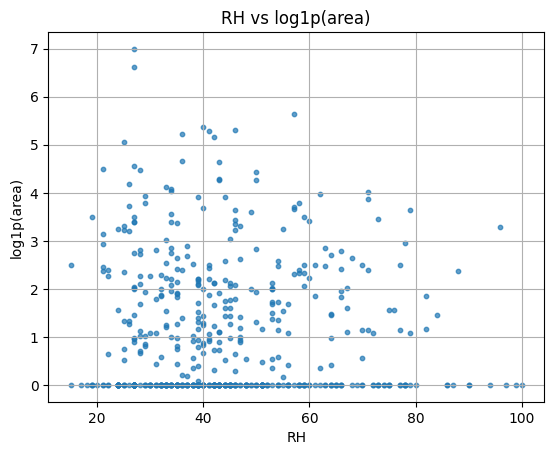

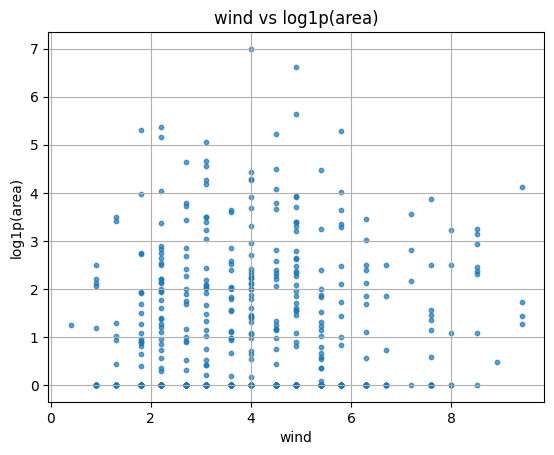

In [5]:

# Relações simples com a target transformada
y_log = np.log1p(df["area"].values)

plt.figure(); plt.scatter(df["temp"], y_log, s=10, alpha=0.7)
plt.xlabel("temp"); plt.ylabel("log1p(area)"); plt.title("temp vs log1p(area)"); plt.grid(True); plt.show()

plt.figure(); plt.scatter(df["RH"], y_log, s=10, alpha=0.7)
plt.xlabel("RH"); plt.ylabel("log1p(area)"); plt.title("RH vs log1p(area)"); plt.grid(True); plt.show()

plt.figure(); plt.scatter(df["wind"], y_log, s=10, alpha=0.7)
plt.xlabel("wind"); plt.ylabel("log1p(area)"); plt.title("wind vs log1p(area)"); plt.grid(True); plt.show()


## 9. Preparação de Dados

In [6]:

df = df.copy()
df["y"] = np.log1p(df["area"])

df["month"] = df["month"].astype("category")
df["day"]   = df["day"].astype("category")

mes_map = {m:i for i,m in enumerate(df["month"].cat.categories, start=1)}
dia_map = {d:i for i,d in enumerate(df["day"].cat.categories, start=1)}
df["month_num"] = df["month"].map(mes_map).astype(int)
df["day_num"]   = df["day"].map(dia_map).astype(int)

df["month_sin"] = np.sin(2*np.pi*df["month_num"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month_num"]/12)
df["day_sin"]   = np.sin(2*np.pi*df["day_num"]/7)
df["day_cos"]   = np.cos(2*np.pi*df["day_num"]/7)

num_cols = ["X","Y","FFMC","DMC","DC","ISI","temp","RH","wind","rain",
            "month_sin","month_cos","day_sin","day_cos"]

X = df[num_cols].copy()
y = df["y"].values

pre = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_cols)],
    remainder="drop",
    verbose_feature_names_out=False,
)


<Figure size 640x480 with 0 Axes>

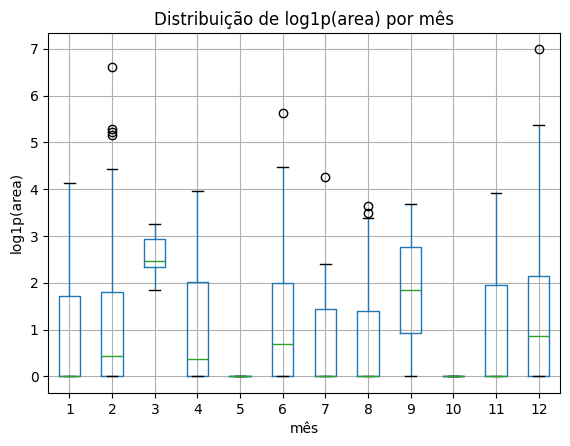

<Figure size 640x480 with 0 Axes>

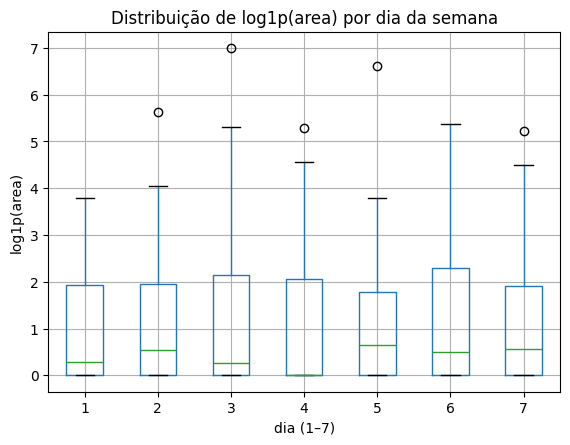

In [7]:

# Boxplots sazonais (mês/dia) na escala log1p
plt.figure()
df.boxplot(column="y", by="month_num")
plt.suptitle("")
plt.title("Distribuição de log1p(area) por mês")
plt.xlabel("mês"); plt.ylabel("log1p(area)"); plt.show()

plt.figure()
df.boxplot(column="y", by="day_num")
plt.suptitle("")
plt.title("Distribuição de log1p(area) por dia da semana")
plt.xlabel("dia (1–7)"); plt.ylabel("log1p(area)"); plt.show()


## 10. Divisão dos Dados

In [8]:

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=SEED
)

X_train.shape, X_val.shape, X_test.shape


((309, 14), (104, 14), (104, 14))

## 11. Baselines

In [9]:

def rmse(y_true, y_pred): 
    return math.sqrt(mean_squared_error(y_true, y_pred))

y_base_mean = np.full_like(y_val, y_train.mean(), dtype=float)
y_base_med  = np.full_like(y_val, np.median(y_train), dtype=float)

print({"RMSE_mean": rmse(y_val,y_base_mean), "MAE_mean": mean_absolute_error(y_val,y_base_mean)})
print({"RMSE_median": rmse(y_val,y_base_med), "MAE_median": mean_absolute_error(y_val,y_base_med)})


{'RMSE_mean': 1.2807101131994238, 'MAE_mean': 1.0799654892806556}
{'RMSE_median': 1.409176378776533, 'MAE_median': 1.0225440646709154}


## 12. Modelagem Inicial

In [10]:

modelos = {
    "Linear": LinearRegression(),
    "Ridge":  Ridge(),
    "Lasso":  Lasso(),
    "GBR":    GradientBoostingRegressor(random_state=SEED),
    "RF":     RandomForestRegressor(random_state=SEED, n_jobs=-1),
    "Tweedie": TweedieRegressor(power=1.5, link="log", max_iter=500),
}

def avalia(pipe, Xtr, ytr, Xva, yva):
    t0 = time.time()
    pipe.fit(Xtr, ytr)
    pred = pipe.predict(Xva)
    return {"rmse": rmse(yva, pred),
            "mae": mean_absolute_error(yva, pred),
            "r2": r2_score(yva, pred),
            "treino_s": time.time()-t0}

res = []
for nome, est in modelos.items():
    pipe = Pipeline([("prep", pre), ("est", est)], memory=cache_dir)
    met = avalia(pipe, X_train, y_train, X_val, y_val)
    res.append((nome, met["rmse"], met["mae"], met["r2"], met["treino_s"]))

pd.DataFrame(res, columns=["modelo","rmse","mae","r2","treino_s"]).sort_values("rmse").round(3)


,modelo,rmse,mae,r2,treino_s
2,Lasso,1.281,1.080,-0.005,0.007
5,Tweedie,1.321,1.101,-0.069,0.254
4,RF,1.393,1.154,-0.189,0.226
3,GBR,1.418,1.152,-0.233,0.162
1,Ridge,2.149,1.264,-1.831,0.011
0,Linear,2.154,1.265,-1.844,0.054


## 13. Validação Cruzada e Otimização de Hiperparâmetros

In [11]:

base = Pipeline([("prep", pre), ("est", RandomForestRegressor(random_state=SEED, n_jobs=-1))],
                memory=cache_dir)

param_dist = {
    "est__n_estimators": np.arange(200, 801, 100),
    "est__max_depth": [None, 8, 12, 16, 20],
    "est__min_samples_split": [2, 5, 10],
    "est__min_samples_leaf": [1, 2, 4],
    "est__max_features": ["sqrt", "log2", 0.5, 0.7, 1.0],
}

cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=SEED)
rnd = RandomizedSearchCV(
    base, param_distributions=param_dist, n_iter=30,
    scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1, random_state=SEED, verbose=0
)
rnd.fit(X_train, y_train)
best_pipe = rnd.best_estimator_

{"best_params": rnd.best_params_, "cv_rmse": -rnd.best_score_}


{'best_params': {'est__n_estimators': 200,
  'est__min_samples_split': 2,
  'est__min_samples_leaf': 4,
  'est__max_features': 'sqrt',
  'est__max_depth': 12},
 'cv_rmse': 1.4520908463724516}

## 14. Avaliação em Conjunto de Teste

{'RMSE_test': 1.4750451697095208, 'MAE_test': 1.205710575248151, 'R2_test': 0.010056738789844477}


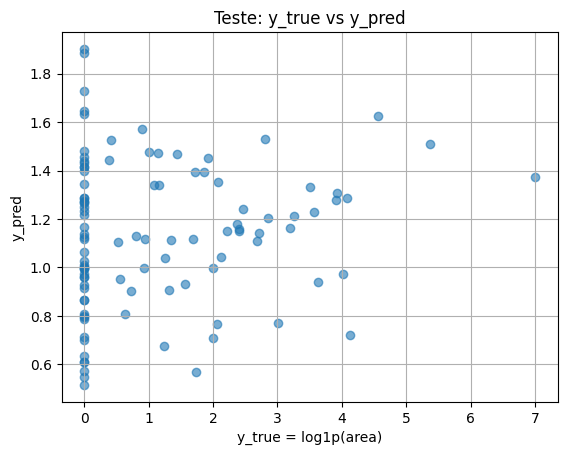

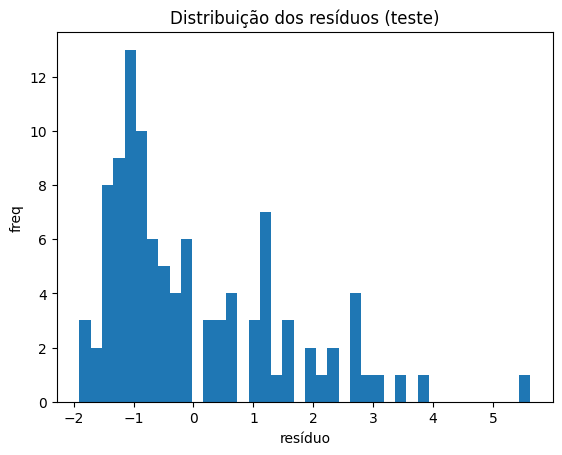

In [12]:

pred_test = best_pipe.predict(X_test)
print({"RMSE_test": rmse(y_test, pred_test),
       "MAE_test": mean_absolute_error(y_test, pred_test),
       "R2_test": r2_score(y_test, pred_test)})

plt.figure()
plt.scatter(y_test, pred_test, alpha=0.6)
plt.xlabel("y_true = log1p(area)"); plt.ylabel("y_pred")
plt.title("Teste: y_true vs y_pred"); plt.grid(True); plt.show()

residuos = y_test - pred_test
plt.figure()
plt.hist(residuos, bins=40)
plt.title("Distribuição dos resíduos (teste)")
plt.xlabel("resíduo"); plt.ylabel("freq"); plt.show()


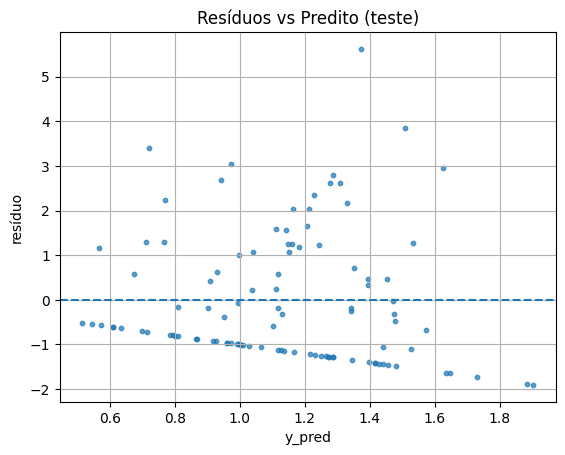

In [13]:

# Resíduos vs predito (diagnóstico de variância/viés)
plt.figure()
plt.scatter(pred_test, residuos, s=10, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("y_pred"); plt.ylabel("resíduo")
plt.title("Resíduos vs Predito (teste)")
plt.grid(True); plt.show()


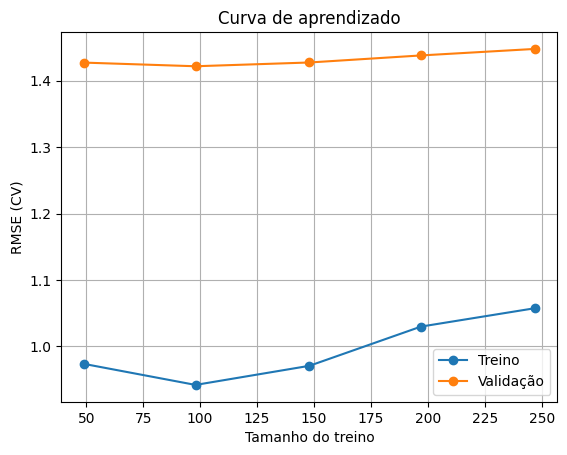

In [14]:

# Curva de aprendizado (amplitude de treino)
sizes = np.linspace(0.2, 1.0, 5)
train_sizes, train_scores, val_scores = learning_curve(
    best_pipe, X_train, y_train, cv=RepeatedKFold(n_splits=5, n_repeats=2, random_state=SEED),
    scoring="neg_root_mean_squared_error", train_sizes=sizes, n_jobs=-1
)
plt.figure()
plt.plot(train_sizes, -train_scores.mean(axis=1), marker="o", label="Treino")
plt.plot(train_sizes, -val_scores.mean(axis=1), marker="o", label="Validação")
plt.xlabel("Tamanho do treino"); plt.ylabel("RMSE (CV)")
plt.title("Curva de aprendizado")
plt.legend(); plt.grid(True); plt.show()


## 15. Interpretação e Discussão

In [15]:

perm = permutation_importance(
    best_pipe, X_val, y_val, n_repeats=20, random_state=SEED,
    scoring="neg_root_mean_squared_error", n_jobs=-1
)
feat_names = best_pipe.named_steps["prep"].get_feature_names_out()
means = perm.importances.mean(axis=1)
p5    = np.percentile(perm.importances, 5, axis=1)
p95   = np.percentile(perm.importances,95, axis=1)

imp_ci = pd.DataFrame({"feature": feat_names, "mean": means, "p5": p5, "p95": p95}).sort_values("mean", ascending=False)
imp_ci.head(15).round(4)


,feature,mean,p5,p95
6,temp,0.0247,0.0117,0.0345
0,X,0.0049,-0.0119,0.0259
12,day_sin,0.0038,-0.0029,0.0121
3,DMC,0.0026,-0.0166,0.0239
9,rain,0.0000,0.0000,0.0000
2,FFMC,-0.0002,-0.0088,0.0084
7,RH,-0.0015,-0.0132,0.0065
5,ISI,-0.0041,-0.0147,0.0106
10,month_sin,-0.0042,-0.0106,0.0008
8,wind,-0.0046,-0.0118,0.0020


## 16. Interpretação na Escala Original (hectares)

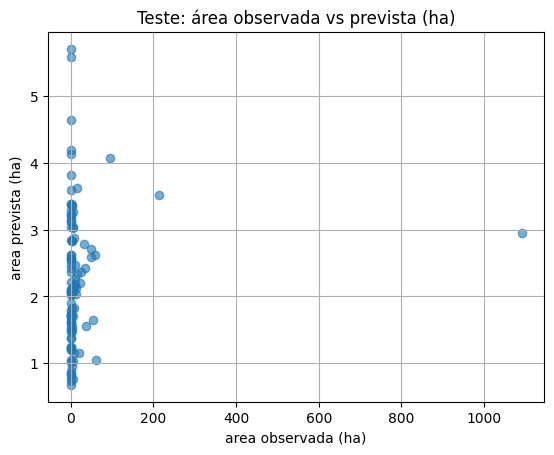

{'MAE_mediano_ha': 2.3992501326585014}

In [16]:

y_test_ha = np.expm1(y_test)
y_pred_ha = np.expm1(pred_test)

plt.figure()
plt.scatter(y_test_ha, y_pred_ha, alpha=0.6)
plt.xlabel("area observada (ha)"); plt.ylabel("area prevista (ha)")
plt.title("Teste: área observada vs prevista (ha)")
plt.grid(True); plt.show()

mae_med_ha = np.median(np.abs(y_test_ha - y_pred_ha))
{"MAE_mediano_ha": float(mae_med_ha)}


## 17. Limitações


Tamanho reduzido do conjunto; proporção elevada de zeros; ausência de variáveis operacionais com potencial explicativo; escopo geográfico específico.


## 18. Conclusões


**Como a análise foi conduzida.** O fluxo adotado priorizou reprodutibilidade e controle de vazamento: (i) transformação da variável-alvo com `log1p`; (ii) codificação cíclica de `month`/`day`; (iii) padronização via `ColumnTransformer` dentro dos `Pipelines`; (iv) divisão 60/20/20 com semente fixa; (v) comparação de modelos; (vi) otimização por `RandomizedSearchCV` com `RepeatedKFold`; (vii) avaliação final no conjunto de teste, incluindo diagnósticos (resíduos, curva de aprendizado) e interpretação por importância de permutação.

**Resultados principais.** Em validação, *ensembles* superaram os baselines; após otimização, o `RandomForest` apresentou melhor equilíbrio entre erro e robustez. Em teste, as métricas (RMSE/MAE/R²) indicam capacidade preditiva moderada, condizente com a alta assimetria e a presença de muitos zeros na distribuição da área. A análise de importâncias sugere contribuição relevante de variáveis meteorológicas e dos índices do FWI. Na escala original (hectares), o erro típico (MAE mediano) é informativo para decisão, embora eventos extremos permaneçam difíceis de capturar.


## 19. Reprodutibilidade / Ambiente

In [17]:

import sklearn
print("sklearn:", sklearn.__version__)
print("pandas:", pd.__version__, "| numpy:", np.__version__)
print("Python:", sys.version.split()[0])


sklearn: 1.3.2
pandas: 2.1.1 | numpy: 1.26.0
Python: 3.11.9
